In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import cos, sin, exp, pi
from scipy.stats import norm
import seaborn as sns
sns.set_style("whitegrid", {'grid.linestyle': '--'})

## 3.3 ベイズ線形回帰

In [2]:
# 多次元乱数生成用の棄却サンプリング

def sample_MD(c, p, N, M):
    p /= p.max()
    samples = []
    for i in range(1000000):
        a = np.random.choice(np.arange(len(c)), M)
        if np.random.rand() < p[tuple(a[::-1])]:
            samples.append(c[a])
        if len(samples) == N:
            break
    return np.array(samples)

3.3.1 パラメータの分布

(-1, 1)

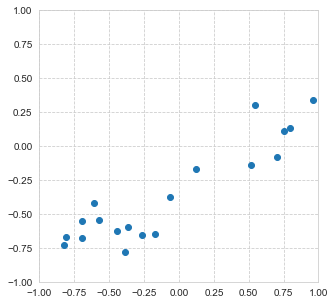

In [3]:
N = 20
a = [-0.3, 0.5]
x = 2 * np.random.rand(N) - 1
t = a[0] + a[1] * x + np.random.normal(0, 0.2, N)
plt.figure(figsize=(5, 5))
plt.scatter(x, t)
plt.xlim(-1, 1)
plt.ylim(-1, 1)

C:\Users\Asunaro\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\Asunaro\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\Asunaro\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In

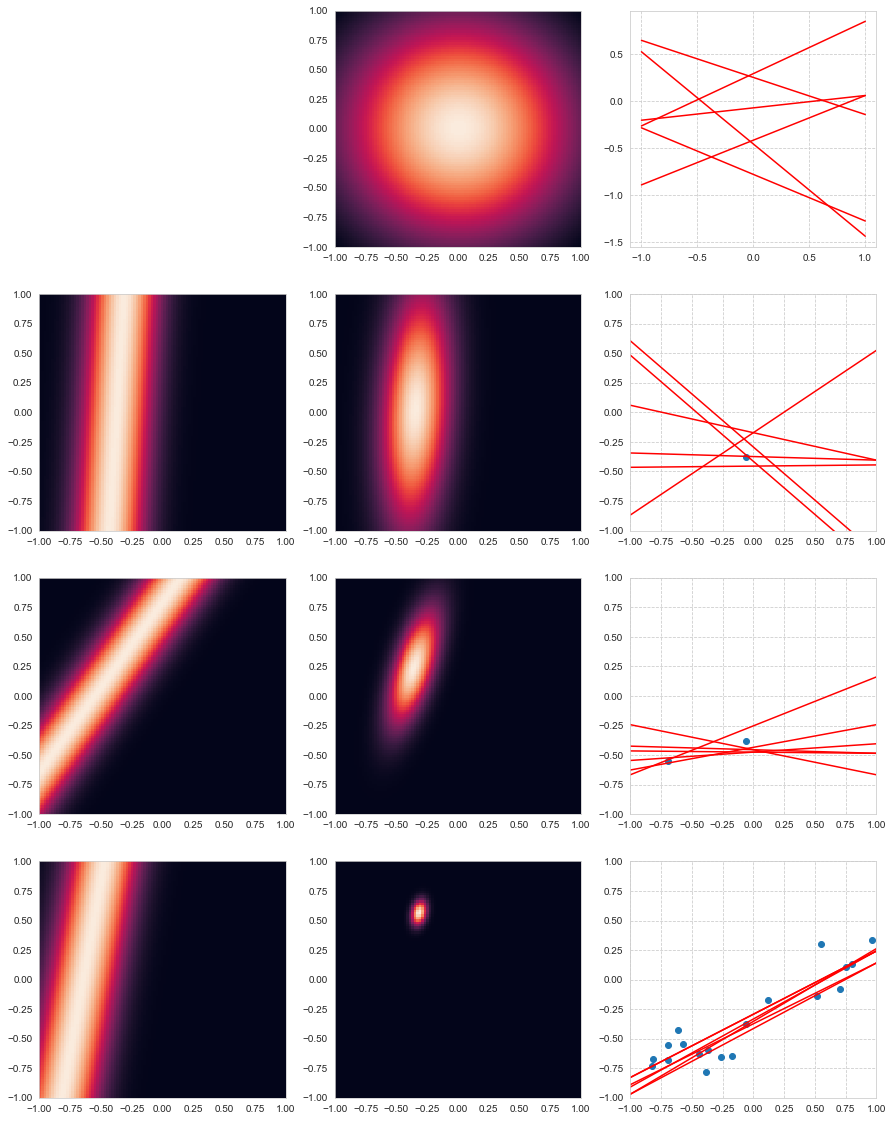

In [4]:
plt.figure(figsize=(15, 20))

alpha = 2.0
beta = 25
M = 2
w_line = np.linspace(-1, 1, 100)
W = np.meshgrid(w_line, w_line)


# 学習前
P_pri = alpha**(1/2) / (2*pi) * exp(-W[0]**2-W[1]**2)
plt.subplot(4, 3, 2)
plt.pcolormesh(W[0], W[1], P_pri)

x_line = np.linspace(-1, 1, 100)
for i in range(6):
    w = sample_MD(w_line, P_pri, 6, M)
    y = w[i, 0] + w[i, 1] * x_line
    plt.subplot(4, 3, 3)
    plt.plot(x_line, y, color='red')

# 学習後

for i, N in enumerate([1, 2, 20]):
    P_like = 1
    for n in range(N):
        p_l = beta**(1/2) / (2*pi) * exp(- beta/2 * (t[n] - (W[0] + W[1] * x[n]))**2)
        P_like *= p_l
    plt.subplot(4, 3, 3*i+4)
    plt.pcolormesh(W[0], W[1], p_l)
    P_post = P_pri * P_like
    P_post /= P_post.max()
    plt.subplot(4, 3, 3*i+5)
    plt.pcolormesh(W[0], W[1], P_post)
    w = sample_MD(w_line, P_post, 6, M)
    plt.subplot(4, 3, 3*i+6)
    for i in range(6):
        y = w[i, 0] + w[i, 1] * x_line
        plt.plot(x_line, y, color='red')
    plt.scatter(x[:N], t[:N])
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    P_pri = P_post.copy()

3.3.2 予測分布

In [5]:
gaussian = lambda x, mu, sigma: exp(-(x-mu)**2 / (2*sigma**2))

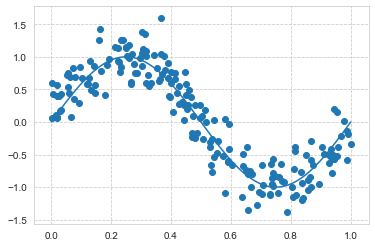

In [6]:
N_train = 200
N_test = 100
x_train = np.random.rand(N_train)
t_train = sin(2*pi*x_train)+np.random.normal(0, 0.25, N_train)
x_test = np.linspace(0, 1, N_test)
t_test = sin(2*pi*x_test)
plt.plot(x_test, t_test)
plt.scatter(x_train, t_train)

In [7]:
# 基底関数の作用->データの前処理(整形)と考える

plt.figure(figsize=(10, 10))
alpha = 2.0
beta = 25
sigma = 0.3
M = 9
phi_train = np.zeros((N_train, M))
phi_test = np.zeros((N_test, M))
for i, mu in enumerate(np.linspace(0, 1, M)):
    phi_train[:, i] = gaussian(x_train, mu, sigma)
    phi_test[:, i] = gaussian(x_test, mu, sigma)


<Figure size 720x720 with 0 Axes>

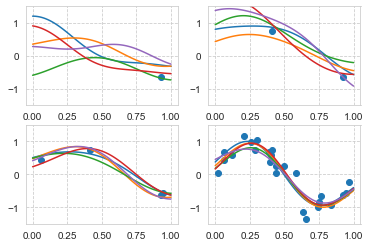

In [8]:
w_test = np.linspace(-1, 1, 10000)
S_list = []
w_mean = []
for i, N in enumerate([1, 2, 4, 25]):
    S_N = np.linalg.inv(alpha * np.identity(M) + beta * phi_train[:N].T @ phi_train[:N])
    m_N = beta * S_N @ phi_train[:N].T @ t_train[:N]
    w = np.random.multivariate_normal(m_N, S_N, (5, 1))
    plt.subplot(2, 2, i+1)
    y = w @ phi_test.T
    for j in range(5):
        plt.plot(x_test, y[j].reshape(-1))
    w_mean.append(m_N)
    S_list.append(S_N)
    plt.scatter(x_train[:N], t_train[:N])
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.5, 1.5)

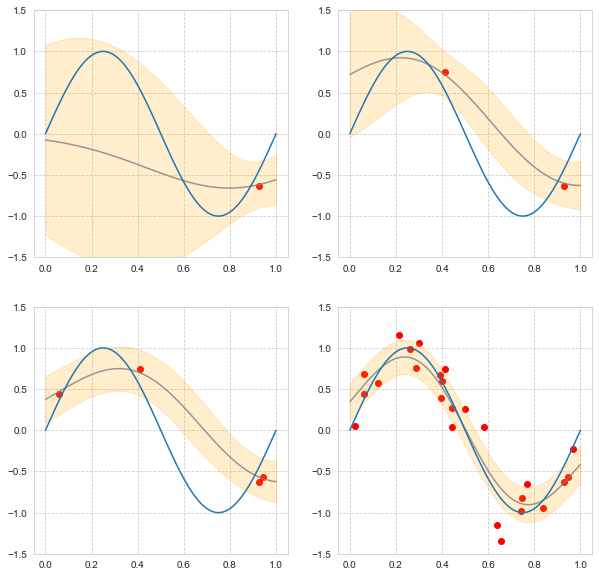

In [9]:
plt.figure(figsize=(10, 10))
for i, N in enumerate([1, 2, 4, 25]):
    y = w_mean[i] @ phi_test.T
    sigma_N = np.sqrt(1 / beta + np.sum(phi_test @ S_list[i] * phi_test, axis=1))
    plt.subplot(2, 2, i+1)
    plt.scatter(x_train[:N], t_train[:N], marker='o', color='red')
    plt.fill_between(x_test, y-sigma_N, y+sigma_N, alpha=0.2, color='orange')
    plt.plot(x_test, y, color='gray', alpha=0.8)
    plt.plot(x_test, t_test)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.5, 1.5)

## 3.5 エビデンス近似

3.5.2 エビデンス関数の最大化

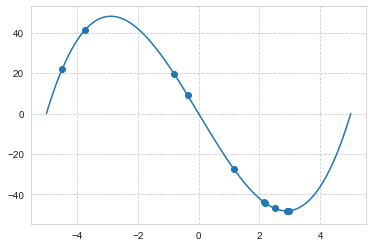

In [102]:
poly = lambda x: (x-5) * x * (x+5)

# データ作成
N_train = 10
N_test = 100
max_M = 9
x_train = 10 * np.random.rand(N_train) - 5
t_train = poly(x_train) + np.random.normal(0, 0.1, N_train)
x_test = np.linspace(-5, 5, N_test)
t_test = poly(x_test)
plt.plot(x_test, t_test)
plt.scatter(x_train, t_train)

In [103]:
# データ整形
phi_train = np.zeros((N_train, max_M))
phi_test = np.zeros((N_test, max_M))
for i in range(max_M):
    phi_train[:, i] = x_train**i
    phi_test[:, i] = x_test**i

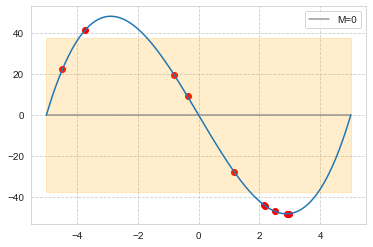

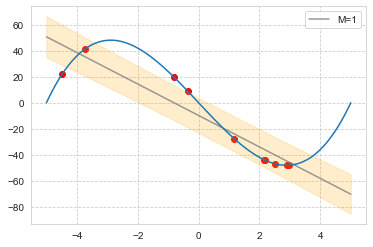

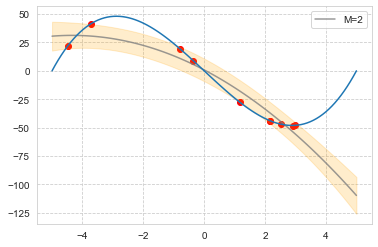

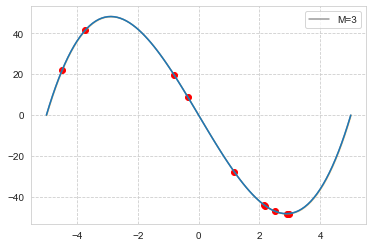

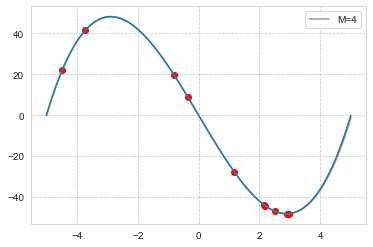

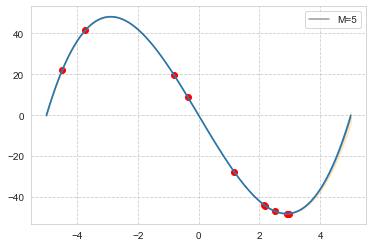

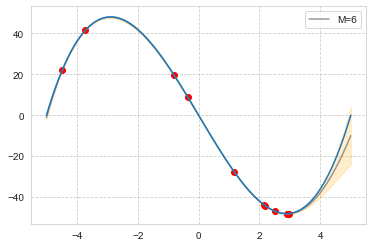

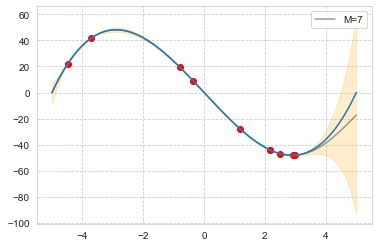

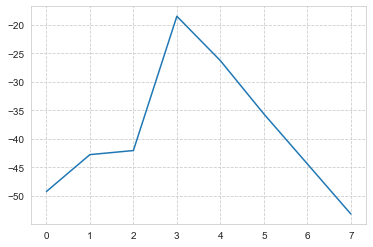

In [104]:

# 学習
E = lambda m_N: (beta/2) * np.sum((t_train - phi_train[:, :M] @ m_N)**2) + (alpha/2) * m_N.T @ m_N
evi_list = []
max_iter = 1000
for M in range(1, max_M):
    alpha = 100
    beta = 100
    eigvelues = np.linalg.eigvalsh(phi_train[:, :M].T @ phi_train[:, :M])
    for i in range(max_iter):
        A = alpha * np.identity(M) + beta * phi_train[:, :M].T @ phi_train[:, :M]
        S_N = np.linalg.inv(A)
        m_N = beta * S_N @ phi_train[:, :M].T @ t_train
        gamma = np.sum(eigvelues / (alpha + eigvelues))
        alpha = float(gamma / (m_N.T @ m_N).clip(min=1e-10))
        beta = float((N_train - gamma) / np.sum((t_train - phi_train[:, :M] @ m_N)**2))
    evidence = (1/2) * (M * np.log(alpha) + N_train * np.log(beta)
                        - np.log(np.linalg.det(A)) - N_train * np.log(2*pi)) - E(m_N)
    evi_list.append(evidence)

    y = m_N @ phi_test[:, :M].T
    sigma_N = np.sqrt(1 / beta + np.sum(phi_test[:, :M] @ S_N * phi_test[:, :M], axis=1))
    plt.scatter(x_train, t_train[:N], marker='o', color='red')
    plt.fill_between(x_test, y-sigma_N, y+sigma_N, alpha=0.2, color='orange')
    plt.plot(x_test, y, color='gray', alpha=0.8, label=f'M={M-1}')
    plt.plot(x_test, t_test)
    # plt.xlim(-5.05, 5.05)
    # plt.ylim(-50, 50)
    plt.legend()
    plt.show()

plt.plot(range(max_M-1), evi_list)